In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
my_face = pd.read_csv('../database/analytical_take_home_data_v3.csv')

In [13]:
my_face.head()

,treatment,company_size,campaign_spend,campaign_budget
0,False,small,10.4477,3.9035
1,False,medium,3.7776,1.9872
2,False,medium,46.1880,55.4523
3,False,small,6.6271,6.5136
4,False,small,92.3405,83.1018


1. How many campaigns have overspend of greater than 1% of their budget in the
control group? In the treatment group?

First, I will create a dataframe called **control** for the control group, and another dataframe called **treatment** for the new product.

In [49]:
 control = my_face.query("treatment == False")

In [31]:
treatment = my_face.query("treatment == True").reset_index()

I'm going to add a column, called **overspending**, with booleans as entries, where True indicates if a company has and overspend greater than 1% of its budget, and False if there is not such overspend, this in order to count how many companies present overspending.

In [20]:
def overspending(data):
    return sum(1 for i in range(data.shape[0]) 
        if data.campaign_spend[i] > data.campaign_budget[i]*1.01)

In [45]:
def overspend_tag(data):
    return [True if data.campaign_spend[i] > data.campaign_budget[i]*1.01 else False 
            for i in range(data.shape[0])]

In [55]:
control['overspending'] = overspend_tag(control)

/tmp/ipykernel_1049044/1141644292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control['overspending'] = overspend_tag(control)


In [112]:
control

,treatment,company_size,campaign_spend,campaign_budget,overspending
0,False,small,10.4477,3.9035,True
1,False,medium,3.7776,1.9872,True
2,False,medium,46.1880,55.4523,False
3,False,small,6.6271,6.5136,True
4,False,small,92.3405,83.1018,True
...,...,...,...,...,...
7728,False,large,93.6252,85.5513,True
7729,False,small,50.2789,49.9137,False
7730,False,small,12.1644,5.0362,True
7731,False,small,1663.3740,621.7328,True


In [74]:
treatment['overspending'] = overspend_tag(treatment)

In [86]:
control.query('overspending == True').shape[0]

5716

In [87]:
treatment.query('overspending == True').shape[0]

5180

As we can see, with the old producto there are 5716 companies withe overspending, meanwhile with the new product there are 5180 companies, which make a difference of 536 companies.

2. Was the new product effective at reducing overspend, and was it more or less
effective depending on the company size? Put together an analysis describing
how the treatment affected overspend.

With the treatment, 536 companies don't present overspending, now it's necessary look the differences between control and treatment groups according to the size of the companies.

In [71]:
def overspending_by_size(data):
    sizes = ['small', 'medium', 'large'] 
    return {s:
            control[np.logical_and(data.company_size == s,
                                   data.overspending == True)].shape[0] 
            for s in sizes}

In [89]:
control_by_size = overspending_by_size(control)

In [113]:
control_by_size

{'small': 3389, 'medium': 452, 'large': 1875}

In [90]:
treatment_by_size = overspending_by_size(treatment)

/tmp/ipykernel_1049044/271622678.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control[np.logical_and(data.company_size == s,


## Pie chart control group 

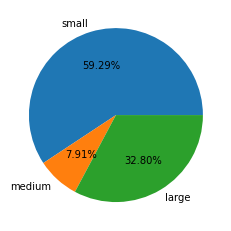

In [98]:
plt.pie(list(control_by_size.values()), 
        labels = list(control_by_size.keys()),
        autopct='%1.2f%%'
       )
plt.show() 

## Pie chart treatment group

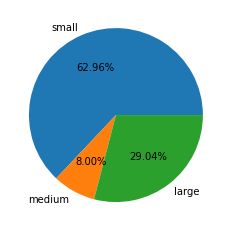

In [99]:
plt.pie(list(treatment_by_size.values()), 
        labels = list(treatment_by_size.keys()),
        autopct='%1.2f%%'
       )
plt.show()

We can see that with the new product, the distribution of overspending remains, but the percentage of small companies increased, and the large companies percentage decreased. So, to figure out more about what happend with the new product, let's calculate the difference with the control and treatment group according with the company size.

In [ ]:
def diff_pct(control, treatment):
    sizes = ['small', 'medium', 'large']
    return {s:
            100*(control[s] - treatment[s])/control[s] for s in sizes}

In [111]:
diff_pct(control_by_size, treatment_by_size)

{'small': 3.8654470345234584, 'medium': 8.4070796460177, 'large': 19.84}

The differences in percentage are the following: the small companies reduced overspending by almost 3.87%, the medium companies reduced by almost 8.41% and for the large companies, the reduction was 19.84%.

With this test we can conclude that there is a reduction of overspending on the three groups of companies, but the reduction is greater for large companies.

3. A product manager on the team is concerned that certain advertisers in the
treatment group are entering lower budgets because they are wary of the new product. Provide some evidence to support their suspicions, or show that any
differences in budgets are likely due to random fluctuations.

For this case the best option is to aply a **two sample Student's t-test**, which is a hypothesis test for the difference between two means of two different samples.

For this test, the null hypothesis and the alternate hypothesis are the following:

$H_0$: $\mu_1 = \mu_2$ vs $H_a$: $\mu_1 \neq \mu_2$.

Let's apply the test over the **overspending** column of the two groups:

In [116]:
sample1 = control['overspending'].astype(int)

In [117]:
sample2 = treatment['overspending'].astype(int)

In [120]:
stats.ttest_ind(sample1, sample2)

Ttest_indResult(statistic=9.567268819264317, pvalue=1.2598213526026748e-21)

As $p<0.05$, the null hypothesis is rejected, so the means of the two samples are statistically differents. In conclusion, the results are not due to random fluctuations.